#**Instacart Market Basket Analysis**


###**Introduction**

The retail industry has lately seen a big tranformation with the availability of the vast amounts of data , providing companies new oppurtunities to understand and analyze customer behavior imrove sales strategies , enhance product availability and optimize inventory with accordance to findings.
We explore the Instacart Market Basket Analysis Dataset which contains information on millions of grocery orders plaved by Instacart customers.

The primary goal of this project is to analyze customer shopping behavior and product relationships to provide helpful recommendations for inventory management , customer engagement , derive meaningful insights that can be used to improve product availabilty , customer retention and sales strategies.

####**Tools and Technologies Used:**
**1.** Apache Hadoop (HDFS & MapReduce):

- Hadoop Distributed File System (HDFS):
was used to store enriched dataset in a distributed fashion , providing scalability and fault tolerance. This allowed us to manage large datasets without running into memory and capacity limitations.

- MapReduce:
We used 'mrjob' python library to implement a MapReduce job that counted product orders. This approach helped us understand the distribution of product popularity across millions of transactions.

**2.** Apache Spark:

- PySpark: A python interface for Apache Spark was used to data integration , enrichment and analysis.


####**Dataset Overview:**

The Instacart Market Basket Dataste consists of 7 CSV files , each providing different information on products and customer transactions:


- Aisles(aisles.csv): Contains information about different aisles , this helps categorize products.

- Departments(departments.csv): Provides department-level categorization for products such as "produce" or "bakery".

- Order Products Prior(order_products_prior.csv): Details the products included in prior orders , this is curcial for analyzin customer purchase history.

- Order Products Train(order_products_train.csv): Contains training data for product orders which can be used for training models to predict future orders.

- Products(products.csv): Information about each and evey product such as product id, name , aisle and department.

- Orders(orders.csv): Details about customer orders such as order ID , user ID, order number , and time details (day of the week and hour).

- Sample Submission(sample_submission.csv): This (primarily used)file provides a sample format for submission in the context of predictive modelling.



**Link to Datastes:** https://www.kaggle.com/competitions/instacart-market-basket-analysis/overview

####**1- loading the data into pyspark**




In [3]:
!pip install pyspark
from pyspark.sql import SparkSession

# start a spark session
spark = SparkSession.builder.master("local[*]").appName("InstacartAnalysis").getOrCreate()

# Load CSVs into Spark DataFrames
aisles_spark = spark.read.csv('/content/aisles.csv', header=True, inferSchema=True)
departments_spark = spark.read.csv('/content/departments.csv', header=True, inferSchema=True)
order_products_prior_spark = spark.read.csv('/content/order_products__prior.csv', header=True, inferSchema=True)
order_products_train_spark = spark.read.csv('/content/order_products__train.csv', header=True, inferSchema=True)
orders_spark = spark.read.csv('/content/orders.csv', header=True, inferSchema=True)
products_spark = spark.read.csv('/content/products.csv', header=True, inferSchema=True)



####**2** - **Data Exploration to understand the relationship between the datasets.**

#####  -  **Aisles**
- Columns : aisle_id , aisle
- Objective : Understand the aisles within the store to which product belongs.

In [4]:
# aisles

from pyspark.sql import functions as F

print(f"Number of Unique Aisles : {aisles_spark.select('aisle').distinct().count()}")
print(aisles_spark.groupBy('aisle').count().orderBy(F.desc('count')).head(10))

Number of Unique Aisles : 134
[Row(aisle='bulk dried fruits vegetables', count=1), Row(aisle='refrigerated', count=1), Row(aisle='soy lactosefree', count=1), Row(aisle='instant foods', count=1), Row(aisle='trail mix snack mix', count=1), Row(aisle='trash bags liners', count=1), Row(aisle='fresh fruits', count=1), Row(aisle='asian foods', count=1), Row(aisle='hair care', count=1), Row(aisle='beers coolers', count=1)]


#####  -  **Departments**

- Columns : department_id , department
- Objective : Understand the departments within the store.

In [5]:
# departments
print(f"Number of unique departments: {departments_spark.select('department').distinct().count()}")
print(departments_spark.groupBy('department').count().orderBy(F.desc('count')).show(10))

Number of unique departments: 21
+---------------+-----+
|     department|count|
+---------------+-----+
|      beverages|    1|
|   meat seafood|    1|
|         frozen|    1|
|           deli|    1|
|dry goods pasta|    1|
|           bulk|    1|
|          other|    1|
|         babies|    1|
|         bakery|    1|
|        produce|    1|
+---------------+-----+
only showing top 10 rows

None


#####  -  **Products**

- Columns : product_id , product_name , aisle_id , department_id
- Objective : Product information that connects to both aisle_id and department_id.

In [6]:
# number of products and their categories
import pandas as pd
products = pd.read_csv('products.csv')

print(f"Total number of products: {products['product_id'].nunique()}")
print(products[['aisle_id', 'department_id']].nunique())

# top products by name occurance

print(products['product_name'].value_counts().head(10))


Total number of products: 49688
aisle_id         134
department_id     21
dtype: int64
product_name
Chocolate Sandwich Cookies                          1
Black Raspberry Water                               1
Organic Egg Whites                                  1
Oikos Yogurt Drink, Strawberry                      1
Peanut Butter Dark Chocolate Protein Chewy Bars     1
Pop Corn, White                                     1
Healthy Kids Organic Chocolate Nutritional Shake    1
Organic Mini Cheddar Cheese Crackers                1
Sesame Flatbread                                    1
No Salt Roasted Pistachios                          1
Name: count, dtype: int64


#####  -  **Orders and Product Orders**

- Columns : order_id , product_id , add_to_cart_order , reordered
- Objective : Represents products within each order , including add_to_cart_order and whether they were reordered.

In [7]:
# prior and train datasets
import pandas as pd

order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_prior = pd.read_csv('order_products__train.csv')

print(f"Total number of order-product pairs (prior): {order_products_prior.shape[0]}")
print(f"Total number of order-product pairs (train): {order_products_prior.shape[0]}")


# the frequence of reordered products

print(order_products_prior['reordered'].value_counts(normalize=True))

# top ordered products in prior dataset

top_prior_products = order_products_prior['product_id'].value_counts().head(10)
print(f"Top ordered products in prior dataset:\n{top_prior_products}")

Total number of order-product pairs (prior): 1384617
Total number of order-product pairs (train): 1384617
reordered
1    0.598594
0    0.401406
Name: proportion, dtype: float64
Top ordered products in prior dataset:
product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
Name: count, dtype: int64


#####  -  **Orders**

- Columns : order_id , user_id , eval_set , order_number , order_dow , order_hour_of_the_day , days_since_prior_order .

- Objective : Insights about individual orders such as user_id when it occured and in which evaluation set it belongs (prior , train or test)

eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


<ipython-input-8-c608e50db7c7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, palette ='magma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

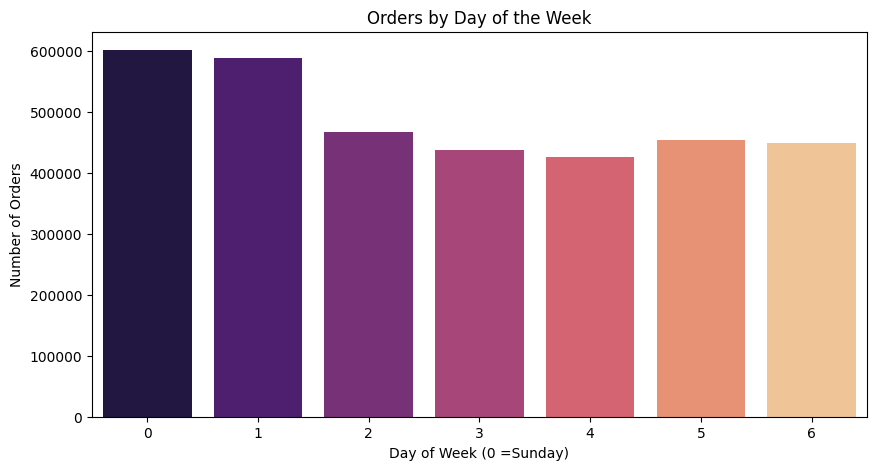

<ipython-input-8-c608e50db7c7>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, palette ='magma')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

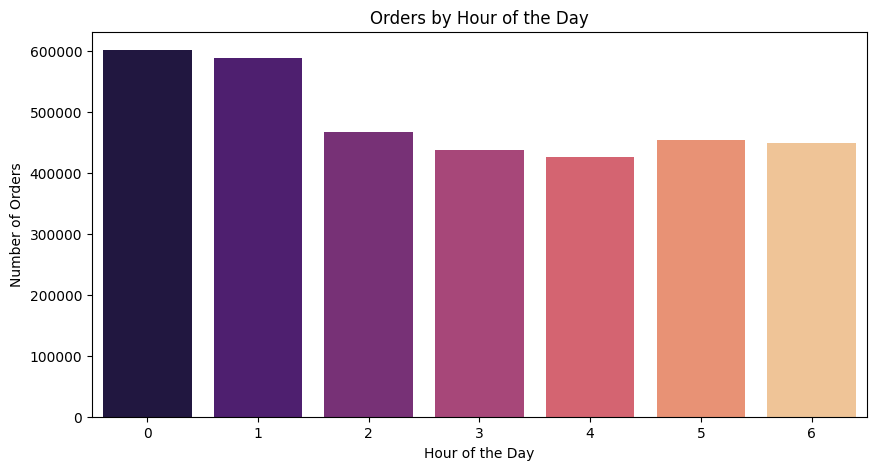

In [8]:
# check distribution of eval_set

import pandas as pd
orders = pd.read_csv('orders.csv')
print(orders['eval_set'].value_counts())

# distributions of orders by day of the week and hour of the day

orders_by_dow = orders['order_dow'].value_counts().sort_index()
orders_by_hour = orders['order_hour_of_day'].value_counts().sort_index()

# import necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns

# plot distribution by day of week

plt.figure(figsize=(10,5))
sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, palette ='magma')
plt.title('Orders by Day of the Week')
plt.xlabel('Day of Week (0 =Sunday)')
plt.ylabel('Number of Orders')
plt.show()

# plot distribution by day of week

plt.figure(figsize=(10,5))
sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, palette ='magma')
plt.title('Orders by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.show()

####**3 - Understanding Relationships Between Datasets :**

**1. Relationships :**
- The products datasets connects to aisles and departments using aisle_id and department_id.
- The order_products_prior and order_products_train datasets link orders (order_id) with products (product_id).
- The orders dataset provides user-level information and context for each other.
- Products and Orders : Adds to order_products_prior and order_products_train details from products (product_name , aisle , department).
- Orders and Users : Links orders_products_prior and order_products_train with orders to provide context about each order , such as user ID , order timing and frequency.

**2. Exploration Queries :**


In [9]:
# re-order rate

reorder_rate = order_products_prior['reordered'].mean()
print(f"Reorder Rate : {reorder_rate: .2f}")

Reorder Rate :  0.60


In [10]:
# customer loyalty , unique customers and orders per customer

from IPython.display import display, HTML

unique_users = orders['user_id'].nunique()
avg_orders_per_user = orders.groupby('user_id')['order_number'].max().mean()
print("Total unique users: ", end="")
display(HTML(f'<span style="color: green; font-weight: normal;">{unique_users}</span>'))
print("Average number of orders per user: ", end="")
display(HTML(f'<span style="color: green; font-weight: normal;">{avg_orders_per_user:.2f}</span>'))

Total unique users: 

Average number of orders per user: 

In [11]:
from IPython.display import display, HTML

# Calculate metrics
unique_users = orders['user_id'].nunique()
avg_orders_per_user = orders.groupby('user_id')['order_number'].max().mean()

print("Total Unique Users: ", end="")
display(HTML(f'<span style="color: green; font-weight: normal;">{unique_users}</span>'))

print("Average Number of Orders Per User: ", end="")
display(HTML(f'<span style="color: green; font-weight: normal;">{avg_orders_per_user:.2f}</span>'))


Total Unique Users: 

Average Number of Orders Per User: 

####**4 - Data Merging :**
**The integration process includes the following steps :**

1. Merging Product Information with Aisles and Departments.
2. Combine Order Product Details with Product Information.
3. Add User-Level Order Info.
4. Export Cleaned Data.

In [12]:
# merge products with aisles and departments

products_full_spark = products_spark.join(aisles_spark, on='aisle_id', how='left') \
    .join(departments_spark, on='department_id', how='left')

# display results

print(products_full_spark.head())

Row(department_id='19', aisle_id='61', product_id=1, product_name='Chocolate Sandwich Cookies', aisle='cookies cakes', department='snacks')


****Explanation:****

- This merge enhances each product by including the aisle and department it is associated with.
- The how='left' ensures that all rows from products dataset are retained with relevant information added from aisles and department.

In [13]:
# convert products_full_spark to pandas DataFrame as its too small for pyspark
products_full_pandas = products_full_spark.toPandas()

# merge order product details with product information
order_products_prior_full = order_products_prior.merge(products_full_pandas, on= 'product_id', how='left') # Use products_full_pandas
order_products_prior_full = order_products_prior.merge(products_full_pandas, on='product_id', how ='left') # Use products_full_pandas and correct variable name

# display results
print(order_products_prior_full.head())
print(order_products_prior_full.head())

   order_id  product_id  add_to_cart_order  reordered department_id aisle_id  \
0         1       49302                  1          1            16      120   
1         1       11109                  2          1            16      108   
2         1       10246                  3          0             4       83   
3         1       49683                  4          0             4       83   
4         1       43633                  5          1            15       95   

                                    product_name                 aisle  \
0                               Bulgarian Yogurt                yogurt   
1  Organic 4% Milk Fat Whole Milk Cottage Cheese  other creams cheeses   
2                          Organic Celery Hearts      fresh vegetables   
3                                 Cucumber Kirby      fresh vegetables   
4           Lightly Smoked Sardines in Olive Oil   canned meat seafood   

     department  
0    dairy eggs  
1    dairy eggs  
2       produce  
3 

****Explanation:****

- By merging order_products_prior and order_products_train with products_full each order gets linked to product details.
- This gives us detailed information like product_name , aisle and department for each order.

In [14]:
# merge order_products_prior_full and order_products_train_full with orders to enrich with user information
import pandas as pd
order_products_prior_enriched = order_products_prior_full.merge(orders, on='order_id', how='left')

# create order_products_train_full by merging order_products_prior with products_full_pandas
order_products_train_full = order_products_prior.merge(products_full_pandas, on='product_id', how ='left') # Changed order_products_train to order_products_prior

order_products_train_enriched = order_products_train_full.merge(orders, on='order_id', how='left')

# display enriched datasets to verify
print(order_products_prior_enriched.head())
print(order_products_train_enriched.head())

   order_id  product_id  add_to_cart_order  reordered department_id aisle_id  \
0         1       49302                  1          1            16      120   
1         1       11109                  2          1            16      108   
2         1       10246                  3          0             4       83   
3         1       49683                  4          0             4       83   
4         1       43633                  5          1            15       95   

                                    product_name                 aisle  \
0                               Bulgarian Yogurt                yogurt   
1  Organic 4% Milk Fat Whole Milk Cottage Cheese  other creams cheeses   
2                          Organic Celery Hearts      fresh vegetables   
3                                 Cucumber Kirby      fresh vegetables   
4           Lightly Smoked Sardines in Olive Oil   canned meat seafood   

     department  user_id eval_set  order_number  order_dow  order_hour_of_

****Explanation:****

- This step adds information such as user_id , order_dow (day of the week), order_hour_of_day and days_since_prior_order.
- This enriched datasets (order_products_prior_enriched and order_products_train_enriched) provide a comprehensive view of each order , including user behavior , product details and purchase time.

####**5 - Handling Missing Values :**

- During Data exploration , i've noticed that the days_since_prior_order column contains 'NaN' values , especially for the first order of a user , this will be replaced with a '0' to indicate "no prev order".

In [15]:
# fill missing values in 'days_since_prior_order'

order_products_prior_enriched['days_since_prior_order'].fillna(0, inplace=True)
order_products_train_enriched['days_since_prior_order'].fillna(0, inplace=True)

# verify if there are any remaining missing values

print(order_products_prior_enriched.isnull().sum())
print(order_products_train_enriched.isnull().sum())

<ipython-input-15-e67a17ca8596>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_products_prior_enriched['days_since_prior_order'].fillna(0, inplace=True)
<ipython-input-15-e67a17ca8596>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
aisle_id                  0
product_name              0
aisle                     0
department                0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64
order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
aisle_id                  0
product_name              0
aisle                     0
department                0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


####**6 - Data Validation and Duplicates-Check :**

In [16]:
# drop duplicates if the exist

order_products_prior_enriched.drop_duplicates(inplace=True)
order_products_train_enriched.drop_duplicates(inplace=True)

# verify the shape of data after dropping duplicates

print(order_products_prior_enriched.shape)
print(order_products_prior_enriched.shape)

(1384617, 15)
(1384617, 15)


In [17]:
# drop duplicates if they exist in Spark DataFrames

!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

# convert Pandas DataFrames to Spark DataFrames
order_products_prior_enriched_spark = spark.createDataFrame(order_products_prior_enriched)
order_products_train_enriched_spark = spark.createDataFrame(order_products_train_enriched)

order_products_prior_enriched_spark = order_products_prior_enriched_spark.dropDuplicates()
order_products_train_enriched_spark = order_products_train_enriched_spark.dropDuplicates()

# verify the number of rows and columns after dropping duplicates
prior_rows = order_products_prior_enriched_spark.count()
train_rows = order_products_train_enriched_spark.count()
prior_columns = len(order_products_prior_enriched_spark.columns)
train_columns = len(order_products_train_enriched_spark.columns)

# print the shape of the data (number of rows and columns)
print(f"Order Products Prior Enriched: {prior_rows} rows, {prior_columns} columns")
print(f"Order Products Train Enriched: {train_rows} rows, {train_columns} columns")

Order Products Prior Enriched: 1384617 rows, 15 columns
Order Products Train Enriched: 1384617 rows, 15 columns


In [18]:
# most popular products

from pyspark.sql import functions as F

popular_products = order_products_prior_enriched_spark.groupBy("product_name").agg(F.count("*").alias("order_count"))
popular_products = popular_products.orderBy(F.desc("order_count"))
popular_products.show(10)


+--------------------+-----------+
|        product_name|order_count|
+--------------------+-----------+
|              Banana|      18726|
|Bag of Organic Ba...|      15480|
|Organic Strawberries|      10894|
|Organic Baby Spinach|       9784|
|         Large Lemon|       8135|
|     Organic Avocado|       7409|
|Organic Hass Avocado|       7293|
|        Strawberries|       6494|
|               Limes|       6033|
| Organic Raspberries|       5546|
+--------------------+-----------+
only showing top 10 rows



**Visualization Description:** The top 10 most ordered products represented by their product ID and order counts.

In [33]:
# number of orders per customer
customer_orders = orders_spark.groupBy("user_id").agg(F.count("order_id").alias("total_orders"))

# identify high-frequency customers
high_freq_customers = customer_orders.filter(customer_orders["total_orders"] > 10)
high_freq_customers.show(10)


+-------+------------+
|user_id|total_orders|
+-------+------------+
|    496|          83|
|    833|          12|
|   1088|          16|
|   1238|          30|
|   2122|          11|
|   2142|          14|
|   2366|          31|
|   2659|          18|
|   2866|          38|
|   3749|          27|
+-------+------------+
only showing top 10 rows



In [19]:
# orderrs by day of the week
orders_per_day = order_products_prior_enriched_spark.groupBy("order_dow").count()
orders_per_day = orders_per_day.orderBy("order_dow")
orders_per_day.show()

# orders by hours of the day
orders_per_hour = order_products_prior_enriched_spark.groupBy("order_hour_of_day").count()
orders_per_hour = orders_per_hour.orderBy("order_hour_of_day")
orders_per_hour.show()


+---------+------+
|order_dow| count|
+---------+------+
|        0|324026|
|        1|205978|
|        2|160562|
|        3|154381|
|        4|155481|
|        5|176910|
|        6|207279|
+---------+------+

+-----------------+------+
|order_hour_of_day| count|
+-----------------+------+
|                0|  9083|
|                1|  5626|
|                2|  3226|
|                3|  2438|
|                4|  2431|
|                5|  3847|
|                6| 11847|
|                7| 36302|
|                8| 67386|
|                9| 93856|
|               10|110479|
|               11|114119|
|               12|111752|
|               13|114762|
|               14|119370|
|               15|116198|
|               16|110237|
|               17| 96944|
|               18| 76522|
|               19| 58175|
+-----------------+------+
only showing top 20 rows



<ipython-input-20-6282b030e5ed>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_per_day_pandas['order_dow'], y=orders_per_day_pandas['count'], palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: Fu

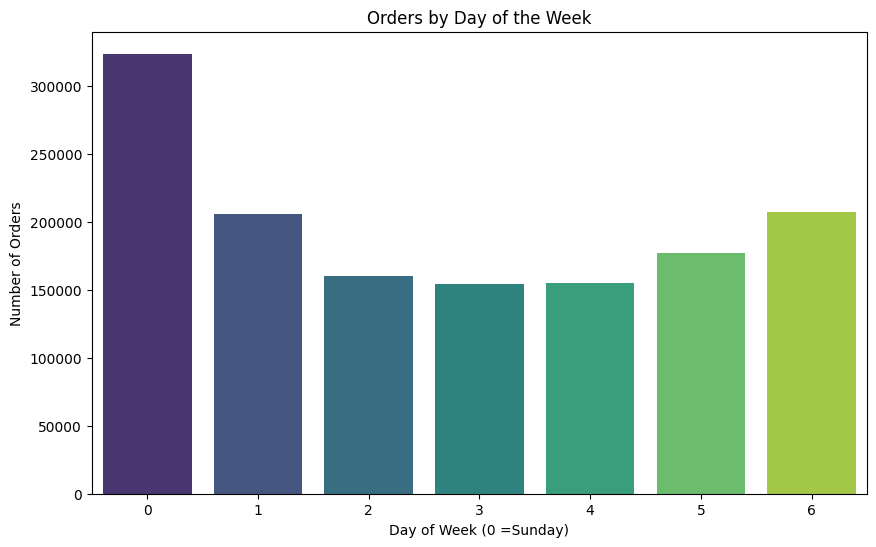

In [20]:
# convert to Pandas for visualization

orders_per_day_pandas = orders_per_day.toPandas()

# plot the data using matplotlib / seaborn

import matplotlib.pyplot as pl
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=orders_per_day_pandas['order_dow'], y=orders_per_day_pandas['count'], palette='viridis')
plt.title('Orders by Day of the Week')
plt.xlabel('Day of Week (0 =Sunday)')
plt.ylabel('Number of Orders')
plt.show()


**Visualization Description:** Days which have higher order volumes , Saturdays have the highest number of orders.

<ipython-input-21-65b4062a3435>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_products_pandas['order_count'], y=popular_products_pandas['product_name'], palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_ba

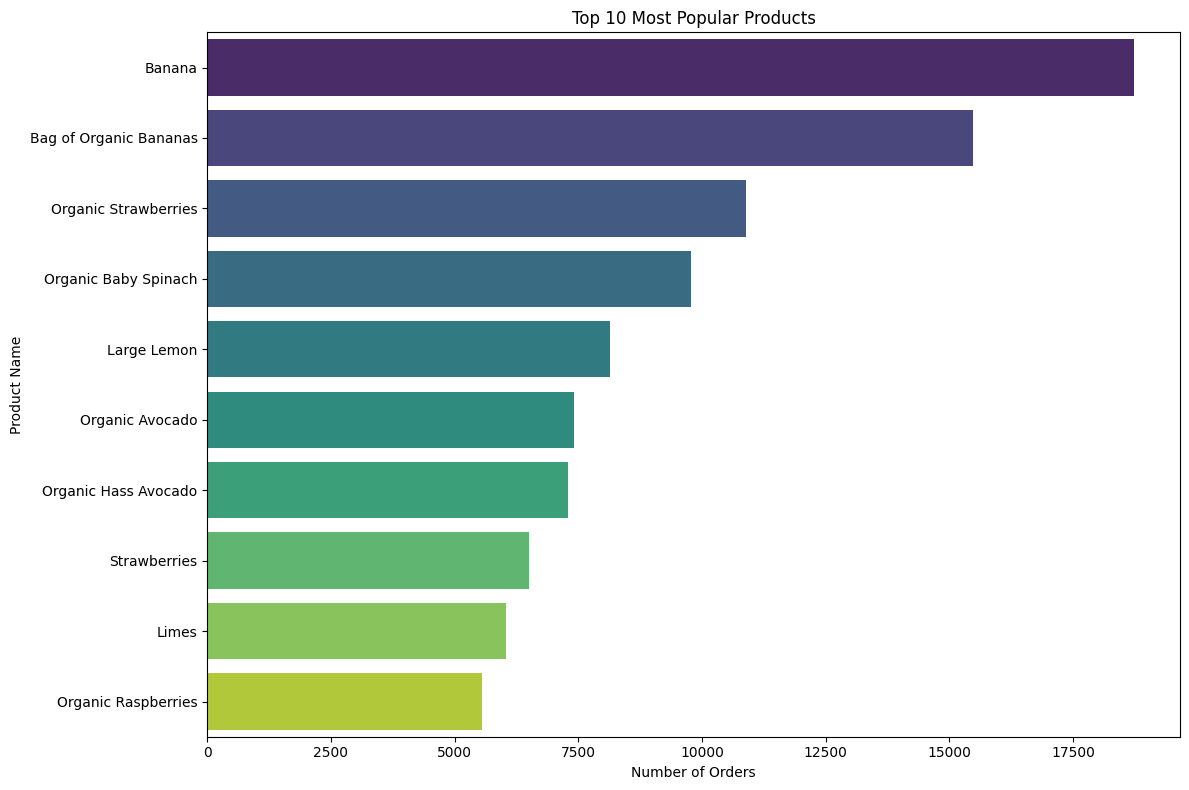

In [21]:
# most popular products and orders by hour

from pyspark.sql import functions as F

popular_products = order_products_prior_enriched_spark.groupBy("product_name").agg(F.count("*").alias("order_count"))
popular_products = popular_products.orderBy(F.desc("order_count")).limit(10)

# convert the result to Pandas for visualization

popular_products_pandas = popular_products.toPandas()

# plot using matplotlib or seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x=popular_products_pandas['order_count'], y=popular_products_pandas['product_name'], palette='viridis')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()


In [22]:
# Save the enriched Spark DataFrames as CSV files for further use
order_products_prior_enriched_spark.write.csv('/content/enriched_order_products_prior_spark.csv', header=True , mode="overwrite")
order_products_train_enriched_spark.write.csv('/content/enriched_order_products_train_spark.csv', header=True , mode="overwrite")


In [23]:
# combine all part files into a single CSV for downloading
!cat /content/enriched_order_products_prior_spark.csv/part-* > /content/enriched_order_products_prior.csv
!cat /content/enriched_order_products_train_spark.csv/part-* > /content/enriched_order_products_train.csv

In [24]:
from google.colab import files

# Download the combined CSV files
files.download('/content/enriched_order_products_prior.csv')
files.download('/content/enriched_order_products_train.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Hadoop MapReduce**

Hadoop HDFS was used to store enriched datasets to ensure scalability and fault tolerance ,  the enriched files (enriched_order_products_prior.csv) and
 (enriched_order_products_train.csv) were uploaded to HDFS, enabling us to handle large volumes of data in a distributed manner.

Hadoop MapReduce was used to perform operations such as counting product orders using the mrjob library.

We accessed hadoop namenode using docker which was configured to run Hadoop services like namenode, datanode , resourcemanager and nodemanager.

In [25]:
# preview data

import pandas as pd

data = pd.read_csv('product_counts_output.txt', sep="\t", header=None, names=["Product ID", "Count"])

data.head()

,Product ID,Count
0,1,76
1,10,119
2,100,20
3,1000,87
4,10000,2


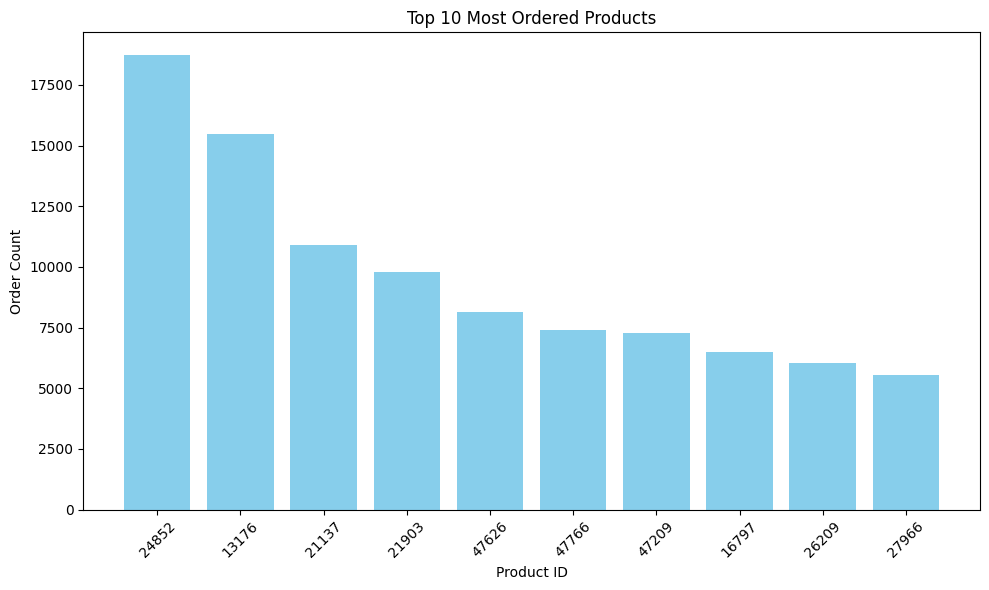

In [26]:
# top 10 ordered products
import matplotlib.pyplot as plt
top_products = data.sort_values(by="Count", ascending=False).head(10)

# plot the top 10 products
plt.figure(figsize=(10, 6))
plt.bar(top_products["Product ID"].astype(str), top_products["Count"], color='skyblue')
plt.xlabel("Product ID")
plt.ylabel("Order Count")
plt.title("Top 10 Most Ordered Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


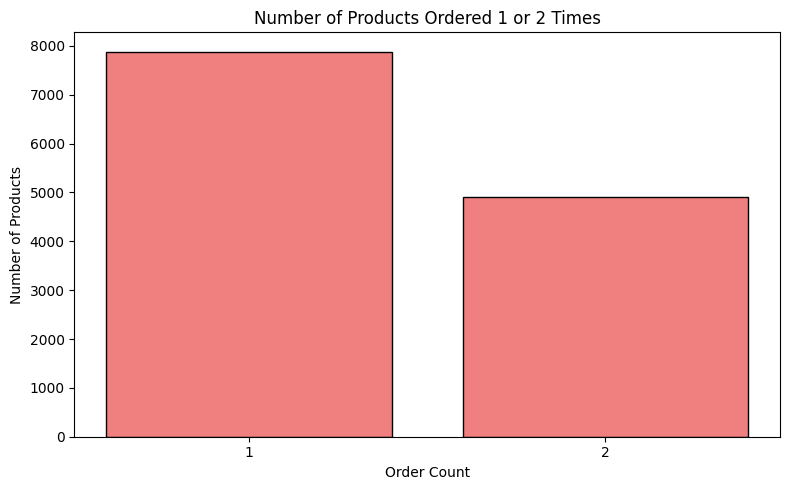

In [28]:
# least ordered products (oredered once or twice)
import matplotlib.pyplot as plt
least_ordered_counts = least_ordered_products["Count"].value_counts().sort_index()

# plotting the least ordered products
plt.figure(figsize=(8, 5))
plt.bar(least_ordered_counts.index.astype(str), least_ordered_counts.values, color='lightcoral', edgecolor='black')
plt.xlabel("Order Count")
plt.ylabel("Number of Products")
plt.title("Number of Products Ordered 1 or 2 Times")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


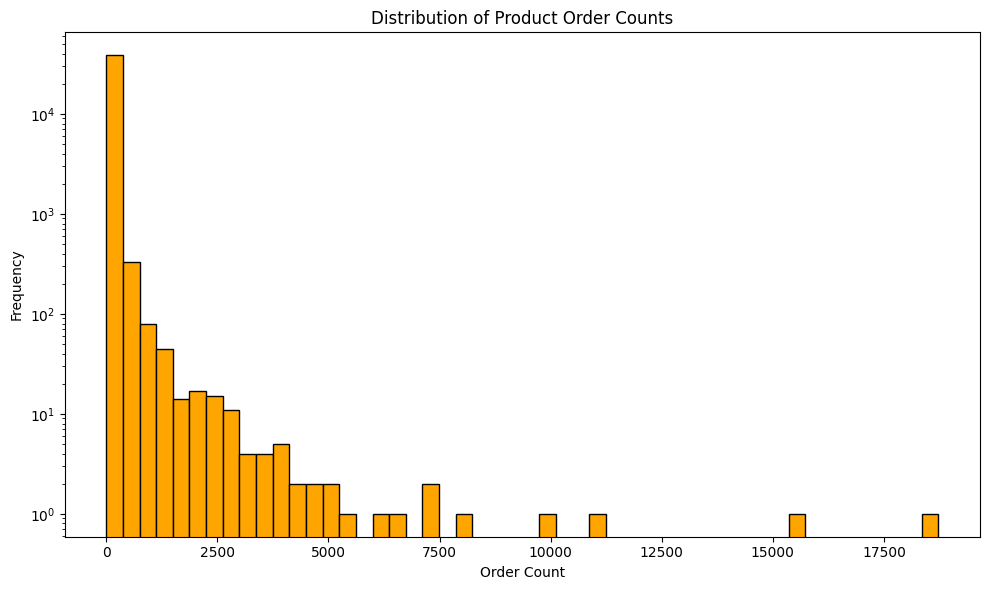

In [31]:
# order counts to understand distribution

plt.figure(figsize=(10,6))
plt.hist(data["Count"], bins=50 , color='orange' , edgecolor='black')
plt.xlabel("Order Count")
plt.ylabel("Frequency")
plt.title("Distribution of Product Order Counts")
plt.yscale("log")
plt.tight_layout()
plt.show()

####Performance Comaprison:

- Executing Speed: In our project , the task of counting product orders using both mapreduce and spark showed a notable difference in performance.

Spark used in-memory processing which reduces time taken for operations that involve multiple stages. Spark processed the product order counts in a faction of the time compared to hadoop mapreduce.

MapReduce is more memory-efficient for batch procesing since it does not require large amounts of memory to store intermediate results. it is more scalable for data that exceeds available memory.

